# maxIter не надо искать, с ним все понятно: bigger is better


### Params Grid Search
Cool way to do gridsearch is `TrainValidationSplit` and `ParamGridBuilder`  
but it is broken for many models including `ALS`  
it doesn't save all params to `bestModel`  
therefore I use my own grid search implementation

see [modeling - How to extract model hyper-parameters from spark.ml in PySpark? - Stack Overflow](https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark)  
maxIter - as rule of thumb: if `abs(metric[i]` - `metric[i - 1]) < 0.001` - stop iteration  
Ну bigger is better, точнее матрица разлагается  
[Тут пишут](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html), что ALS typically converges to a reasonable solution in 20 iterations or less. Хз мне кажется мало, потому что чет не очень в тему предлагает по жанрам)

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setCheckpointDir('checkpoint/') # https://stackoverflow.com/a/31484461

In [121]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.sql.types import *
from random import randint, uniform
from multiprocessing.dummy import Pool # dummy means threads, not real processes
import matplotlib.pyplot as plt
import numpy as np

In [43]:
ratings_schema = StructType([
    StructField('user'     , IntegerType()),
    StructField('movie'    , IntegerType()),
    StructField('rating'   , DoubleType() ),
    StructField('timestamp', LongType()   ),
])

ratings = spark.read.csv('ml-latest-small/ratings.csv', header=True, schema=ratings_schema).select(['user' , 'movie', 'rating'])
ratings.show(5)

+----+-----+------+
|user|movie|rating|
+----+-----+------+
|   1|    1|   4.0|
|   1|    3|   4.0|
|   1|    6|   4.0|
|   1|   47|   5.0|
|   1|   50|   5.0|
+----+-----+------+
only showing top 5 rows



# Random Search for Best Params

In [89]:
param_search_config = {
    'rank'    : {'range': (4    , 12 ), 'dtype': int  },
    'regParam': {'range': (0.001, 0.4), 'dtype': float},
    'alpha'   : {'range': (1.0  , 60 ), 'dtype': float},
}

iterations = 3

param_list = []

for i in range(iterations):
    p = {}
    for param, config in param_search_config.items():
        if config['dtype'] is int:
            rand_func = randint
        if config['dtype'] is float:
            rand_func = uniform
        p[param] = rand_func(config['range'][0], config['range'][1])
    param_list.append(p)
    
param_list

[{'rank': 11, 'regParam': 0.01466859469661283, 'alpha': 34.060979731990194},
 {'rank': 12, 'regParam': 0.16493165591162007, 'alpha': 54.33731362066938},
 {'rank': 11, 'regParam': 0.016232507674970403, 'alpha': 53.21284559409451}]

In [90]:
param_fixed = {
    'userCol'          : 'user' , 
    'itemCol'          : 'movie' ,
    'ratingCol'        : 'rating',
    'coldStartStrategy': 'drop'  ,
    'nonnegative'      : True    ,
    'implicitPrefs'    : True    ,
    'maxIter'          : 20      ,
}

In [91]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [92]:
def evaluate_params(params, model_class, param_fixed, evaluator, train, test):
    model = model_class(**params, **param_fixed)
    predictions = model.fit(train).transform(test)
    return evaluator.evaluate(predictions)

def cv(params):
    cv_folds = 3
    score = 0
    for i in range(cv_folds):
        train, test = ratings.randomSplit([0.8, 0.2])
        score += evaluate_params(
            params      = params     ,
            model_class = ALS        ,
            param_fixed = param_fixed,
            evaluator   = evaluator  ,
            train       = train      ,
            test        = test       ,
        )
    return (params, score / cv_folds)
        
# pool = Pool(processes=len(param_list))
pool = Pool(processes=30)
z = pool.map(cv, param_list)

False

In [117]:
params_sorted = sorted(
    z,
    key = lambda x: x[1],
    reverse = evaluator.isLargerBetter()
)

for i in params_sorted:
    print(i)

({'rank': 12, 'regParam': 0.16493165591162007, 'alpha': 54.33731362066938}, 2.859226641085582)
({'rank': 11, 'regParam': 0.016232507674970403, 'alpha': 53.21284559409451}, 2.8657195507820004)
({'rank': 11, 'regParam': 0.01466859469661283, 'alpha': 34.060979731990194}, 2.8802479994217314)


# Prediction using best params

In [123]:
best_params = params_sorted[0][0]

train, test = ratings.randomSplit([0.8, 0.2])
model = ALS(**best_params, **param_fixed)
predictions = model.fit(train).transform(test)

In [124]:
rating_pred = predictions.rdd.map(lambda x: x.prediction).collect()
rating_true = predictions.rdd.map(lambda x: x.rating    ).collect()

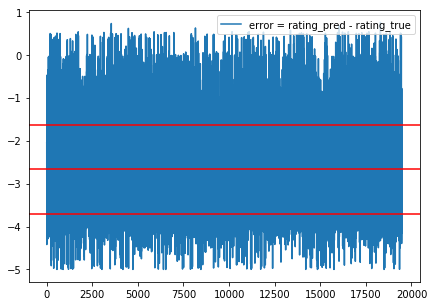

In [125]:
error = np.array(rating_pred) - np.array(rating_true)
mean = error.mean()
std  = error.std() 

plt.figure(figsize=(7, 5))
plt.plot(error, label='error = rating_pred - rating_true')
plt.axhline(mean      , color='r')
plt.axhline(mean - std, color='r')
plt.axhline(mean + std, color='r')
plt.legend(loc=1)

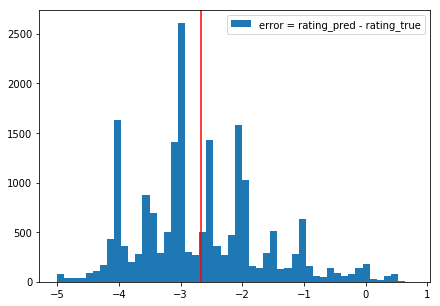

In [126]:
plt.figure(figsize=(7, 5))
plt.hist(error, bins=50, label='error = rating_pred - rating_true')
plt.axvline(x=mean, color='red')
plt.legend(loc=1)